In [1]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pgeocode

import ranky
import properscoring #modified version in github/tozech

from pvlib import forecast, clearsky, atmosphere, solarposition
from pvlib.location import Location

%matplotlib notebook

/home/tzech/Repo/pvlib-python/pvlib/forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


## Data

In [2]:
fname_pat = os.path.expanduser("~/data/pv/ausgrid/*.csv")
fnames = glob.glob(fname_pat)

In [3]:
fnames

['/home/tzech/data/pv/ausgrid/2011-2012 Solar home electricity data v2.csv',
 '/home/tzech/data/pv/ausgrid/2010-2011 Solar home electricity data.csv',
 '/home/tzech/data/pv/ausgrid/2012-2013 Solar home electricity data v2.csv']

Load the first year for training and exploration.

In [4]:
fname = '/home/tzech/data/pv/ausgrid/2010-2011 Solar home electricity data.csv'

In [5]:
data = pd.read_csv(fname, skiprows=1)

In [6]:
data.head()

,Customer,Generator Capacity,Postcode,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00
0,1,3.78,2076,GC,1-Jul-10,0.303,0.471,0.083,0.121,0.361,...,0.495,0.54,0.406,0.543,0.495,0.216,0.378,0.128,0.078,0.125
1,1,3.78,2076,CL,1-Jul-10,1.250,1.244,1.256,0.744,0.019,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.075
2,1,3.78,2076,GG,1-Jul-10,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,3.78,2076,GC,2-Jul-10,0.116,0.346,0.122,0.079,0.120,...,0.262,1.10,1.012,0.817,0.526,0.335,0.402,0.142,0.120,0.111
4,1,3.78,2076,CL,2-Jul-10,1.238,1.238,1.256,1.250,0.169,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.088


### Convert postal code to geo coordinates

In [7]:
data = data.rename({'Postcode': 'postal_code'}, axis=1)
data['postal_code'] = data['postal_code'].astype('str')
postal_codes = data['postal_code'].unique()
postal_codes

array(['2076', '2259', '2263', '2220', '2261', '2230', '2126', '2262',
       '2026', '2218', '2265', '2208', '2229', '2085', '2250', '2283',
       '2305', '2285', '2300', '2093', '2025', '2041', '2303', '2082',
       '2284', '2137', '2048', '2282', '2205', '2224', '2021', '2290',
       '2010', '2135', '2251', '2162', '2227', '2295', '2190', '2029',
       '2204', '2031', '2039', '2087', '2074', '2330', '2291', '2119',
       '2099', '2066', '2100', '2081', '2320', '2134', '2280', '2289',
       '2294', '2159', '2008', '2209', '2203', '2278', '2079', '2228',
       '2044', '2046', '2111', '2077', '2018', '2325', '2324', '2196',
       '2231', '2120', '2260', '2292', '2293', '2086', '2207', '2096',
       '2047', '2233', '2034', '2092', '2264', '2037', '2296', '2286',
       '2200', '2219', '2315', '2211', '2154', '2088', '2198', '2326',
       '2084', '2321', '2281', '2216'], dtype=object)

In [8]:
nomi = pgeocode.Nominatim('au')
geodata = nomi.query_postal_code(postal_codes)

In [9]:
data = data.merge(geodata, on='postal_code')

In [10]:
data.columns

Index(['Customer', 'Generator Capacity', 'postal_code', 'Consumption Category',
       'date', '0:30', '1:00', '1:30', '2:00', '2:30', '3:00', '3:30', '4:00',
       '4:30', '5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00', '8:30',
       '9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30',
       '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30',
       '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
       '21:00', '21:30', '22:00', '22:30', '23:00', '23:30', '0:00',
       'country code', 'place_name', 'state_name', 'state_code', 'county_name',
       'county_code', 'community_name', 'community_code', 'latitude',
       'longitude', 'accuracy'],
      dtype='object')

## Restrict the dataset

Select a single customer and the PV power only.

In [11]:
customer0 = data['Customer'].unique()[0]
sel_cus_gen = data['Customer'] == customer0
sel_cus_gen &= data['Consumption Category'] == 'GG'
df = data.loc[sel_cus_gen]

In [12]:
df.Customer.unique(), df.postal_code.unique(), df['Consumption Category'].unique()

(array([1]), array(['2076'], dtype=object), array(['GG'], dtype=object))

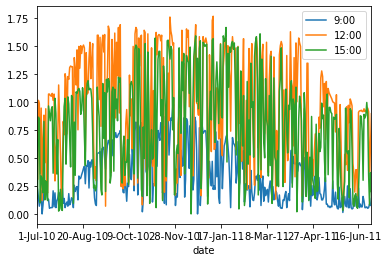

In [13]:
df[['date', '9:00', '12:00', '15:00']].set_index('date').plot()

## Persistence Ensemble

Persistence Ensemble for each time of the day. Building the ensemble from the previous 9 days. After sorting they form the percentiles 10% to 90%.

In [14]:
timeOfDay = '12:00'
ts = df[['date', timeOfDay]].set_index('date')
ts.columns = ['obs']
max_delay = 9
peEn_cols = []
for d in range(1, max_delay+1):
    d_str = '-{0}d'.format(d)
    peEn_cols.append(d_str)
    ts[d_str] = ts.shift(d)['obs']

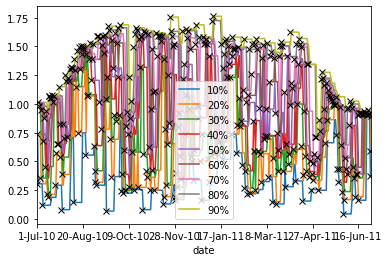

In [15]:
peEn = ts[peEn_cols].apply(lambda s: s.sort_values().values, axis=1, result_type='expand')
peEn.columns = ['{}%'.format(x) for x in range(10, 100, 10)]
peEn.plot()
ts['obs'].plot(style='kx')

## Validation

Exclude the first 10 days, since they are needed for training of persistence ensemble.

In [16]:
def exclude_first10days(d):
    return d.iloc[10:, :]

obs = exclude_first10days(ts)['obs']
ens = exclude_first10days(peEn)

### mean CRPS and its components for the PeEn

The mean CRPS of the PeEn can be compared to its uncertainty component. The latter should conincide with the mean CRPS of the complete hisitory ensemble CH-En.

In [17]:
properscoring.mean_crps(obs.values, ens.values)

(0.28583293340288646,
 0.035878513743040484,
 0.02171010721974398,
 0.27166452687959)

### Rank histogram

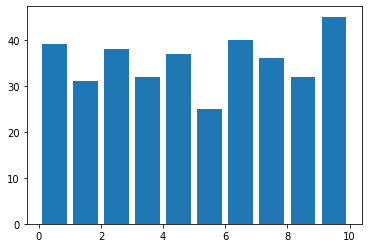

In [18]:
def rankhist(meas_ts, df_ens):
    mask = [True for x in meas_ts.values]
    rh, bins = ranky.rankz(meas_ts.values, df_ens.values.T, mask)
    return rh, bins

def plot_rankhist(rh, bins, normalize=False):
    fig, ax = plt.subplots()
    if normalize:
        rh = rh / np.sum(rh)
    ax.bar(bins[:-1], rh)
    return fig, ax

rh, bins = rankhist(obs, ens)
fig, ax = plot_rankhist(rh, bins)

### Reliability diagram

In [19]:
verif_quantiles = pd.Series(dict([(c, (ens[c] > obs).sum() / len(obs)) for c in ens.columns]))
verif_quantiles

10%    0.104225
20%    0.194366
30%    0.295775
40%    0.391549
50%    0.495775
60%    0.560563
70%    0.673239
80%    0.763380
90%    0.864789
dtype: float64

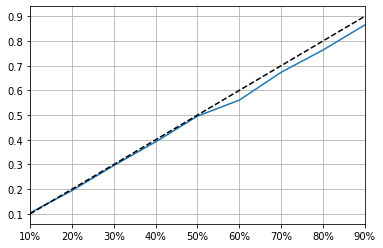

In [20]:
fig, ax = plt.subplots()
verif_quantiles.plot(ax=ax)
ax.plot(np.linspace(0.1, 0.9, 9), 'k--')
ax.grid(True)